In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import math
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn import metrics

df1 = pd.read_csv("cardiotoxity-1.csv")
df1['tr-1'] = pd.read_csv("cardiotoxity-1.csv")['Toxicity Value']
df1['tr-5'] = pd.read_csv("cardiotoxity-5.csv")['Toxicity Value']
df1['tr-10'] = pd.read_csv("cardiotoxity-10.csv")['Toxicity Value']
df1['tr-30'] = pd.read_csv("cardiotoxity-30.csv")['Toxicity Value']
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1547 entries, 0 to 1546
Data columns (total 11 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   TAID              1547 non-null   object 
 1   Name              441 non-null    object 
 2   IUPAC Name        1291 non-null   object 
 3   PubChem CID       1295 non-null   float64
 4   Canonical SMILES  1547 non-null   object 
 5   InChIKey          1295 non-null   object 
 6   Toxicity Value    1547 non-null   int64  
 7   tr-1              1547 non-null   int64  
 8   tr-5              1547 non-null   int64  
 9   tr-10             1547 non-null   int64  
 10  tr-30             1547 non-null   int64  
dtypes: float64(1), int64(5), object(5)
memory usage: 133.1+ KB


<AxesSubplot:>

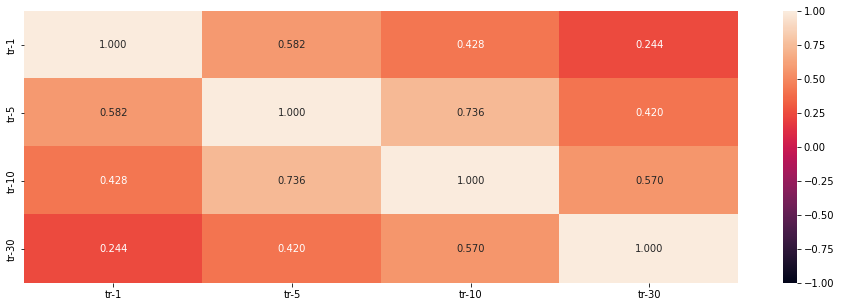

In [2]:
df1.drop(['IUPAC Name', 'PubChem CID', 'InChIKey', 'Toxicity Value'], axis=1, inplace=True)
df1 = df1.drop_duplicates()
corr = df1.corr()
plt.figure(figsize = (16,5))
sns.heatmap(corr, vmax=1, vmin=-1,
            xticklabels=corr.columns.values,
            yticklabels=corr.columns.values,
            annot=True, fmt=".3f")

In [3]:
df1['allOnes'] = df1['tr-1'] + df1['tr-5'] + df1['tr-10'] + df1['tr-30']

In [4]:
df1.describe()

,tr-1,tr-5,tr-10,tr-30,allOnes
count,1547.000000,1547.000000,1547.000000,1547.000000,1547.000000
mean,0.225598,0.462185,0.613445,0.829994,2.131222
std,0.418111,0.498729,0.487118,0.375760,1.421140
min,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,1.000000,1.000000
50%,0.000000,0.000000,1.000000,1.000000,2.000000
75%,0.000000,1.000000,1.000000,1.000000,3.000000
max,1.000000,1.000000,1.000000,1.000000,4.000000


In [5]:
df1.head(10)


,TAID,Name,Canonical SMILES,tr-1,tr-5,tr-10,tr-30,allOnes
0,TOX-74,NaN,S=c1nc[nH]c2nc[nH]c12,0,0,1,1,2
1,TOX-81,NaN,[NH3+][C@@H](CC(=O)N1CCn2c(nnc2C(F)(F)F)C1)Cc1...,0,0,0,0,0
2,TOX-102,lamotrigine,Nc1nnc(-c2cccc(Cl)c2Cl)c(N)n1,0,0,0,0,0
3,TOX-125,Ezetimibe,O=C1[C@H](CC[C@H](O)c2ccc(F)cc2)[C@@H](c2ccc(O...,0,0,0,1,1
4,TOX-133,Keoxifene,O=C(c1ccc(OCC[NH+]2CCCCC2)cc1)c1c(-c2ccc(O)cc2...,0,0,0,1,1
5,TOX-162,riluzole,Nc1nc2ccc(OC(F)(F)F)cc2s1,0,0,0,1,1
6,TOX-163,cilostazol,O=C1CCc2cc(OCCCCc3nnnn3C3CCCCC3)ccc2N1,1,1,1,1,4
7,TOX-174,NaN,[NH3+]CC1(CC(=O)[O-])CCCCC1,0,0,0,0,0
8,TOX-181,NaN,NC(=O)C(c1ccccc1)(c1ccccc1)[C@@H]1CC[NH+](CCc2...,1,1,1,1,4
9,TOX-183,clotrimazole,Clc1ccccc1C(c1ccccc1)(c1ccccc1)n1ccnc1,0,1,1,1,3


In [6]:
df2 = pd.read_table('cardiotoxity-regression.txt', sep='\t')
df2.head()

,SAMPLE_ID,SAMPLE_DATA_ID,PROTOCOL_NAME,SAMPLE_DATA_TYPE,ASSAY_OUTCOME,CURVE_CLASS2,AC50,EFFICACY,ZERO_ACTIVITY,INF_ACTIVITY,...,CAS,PUBCHEM_CID,PUBCHEM_SID,PURITY_RATING,PURITY_RATING_4M,SAMPLE_NAME,SMILES,TOX21_ID,PURITY,Unnamed: 55
0,NCGC00255163-01,243694629,tox21-herg-u2os-p1,set1,NaN,4.0,0.691666,-7.041105,3.000000,-4.041105,...,71-23-8,1031.0,144212757,A,Ac,1-Propanol,CCCO,Tox21_302440,NaN,NaN
1,NCGC00257537-01,243694636,tox21-herg-u2os-p1,set1,NaN,4.0,NaN,0.000000,0.000000,0.000000,...,640-19-7,12542.0,144211614,A,A,2-Fluoroacetamide,FCC(N)=O,Tox21_301297,NaN,NaN
2,NCGC00258978-01,243698196,tox21-herg-u2os-p1,set1,NaN,4.0,NaN,0.000000,0.000000,0.000000,...,106-93-4,7839.0,144208625,AC,F,"1,2-Dibromoethane",BrCCBr,Tox21_201427,NaN,NaN
3,NCGC00259980-01,243698197,tox21-herg-u2os-p1,set1,NaN,4.0,NaN,0.000000,0.000000,0.000000,...,627-03-2,12301.0,144209629,A,A,Ethoxyacetic acid,O=C(O)COCC,Tox21_202431,NaN,NaN
4,NCGC00259084-01,243698200,tox21-herg-u2os-p1,set1,NaN,4.0,2.533001,6.038564,-1.538564,4.500000,...,756-79-6,12958.0,144208732,A,Ac,Dimethyl methylphosphonate,CP(=O)(OC)OC,Tox21_201534,NaN,NaN


In [7]:
df2['AC50'] = df2['AC50'].fillna(0)
df2.describe()

,SAMPLE_DATA_ID,ASSAY_OUTCOME,CURVE_CLASS2,AC50,EFFICACY,ZERO_ACTIVITY,INF_ACTIVITY,HILL_COEF,R2,P_HILL,...,CONC10,CONC11,CONC12,CONC13,CONC14,CONC15,PUBCHEM_CID,PUBCHEM_SID,PURITY,Unnamed: 55
count,3.335400e+04,0.0,33354.000000,33354.000000,33336.000000,33336.000000,33336.000000,14493.000000,14493.000000,14500.000000,...,3.335400e+04,3.335400e+04,3.335400e+04,3.335400e+04,3.194600e+04,0.0,3.292200e+04,3.335400e+04,0.0,0.0
mean,2.437163e+08,NaN,3.106839,8.933008,-9.015239,-0.022833,-9.038073,2.996375,0.680513,0.113425,...,2.968878e-06,6.638705e-06,1.484602e-05,3.319226e-05,6.990359e-05,NaN,2.584249e+06,1.530006e+08,NaN,NaN
std,1.573908e+04,NaN,2.126282,18.513233,25.820883,3.273379,25.482049,1.593897,0.228873,0.128467,...,1.459510e-05,3.264665e-05,7.299444e-05,1.632333e-04,3.723828e-04,NaN,9.176075e+06,2.076752e+07,NaN,NaN
min,2.436892e+08,NaN,-3.000000,0.000000,-183.888768,-127.816972,-184.752711,0.200000,0.300186,0.000000,...,1.149000e-08,2.570000e-08,5.747000e-08,1.285000e-07,2.874000e-07,NaN,4.000000e+00,1.442055e+08,NaN,NaN
25%,2.436985e+08,NaN,4.000000,0.000000,-8.867665,0.000000,-4.168976,1.538589,0.460197,0.000174,...,1.757000e-06,3.929000e-06,8.785000e-06,1.964000e-05,3.831000e-05,NaN,7.451250e+03,1.442097e+08,NaN,NaN
50%,2.437214e+08,NaN,4.000000,0.000000,0.000000,0.000000,0.000000,2.720221,0.684525,0.050205,...,3.065000e-06,6.854000e-06,1.533000e-05,3.427000e-05,7.663000e-05,NaN,1.710900e+04,1.442125e+08,NaN,NaN
75%,2.437297e+08,NaN,4.000000,10.682196,0.000000,0.000000,0.000000,4.954917,0.914507,0.224937,...,3.065000e-06,6.854000e-06,1.533000e-05,3.427000e-05,7.663000e-05,NaN,9.283900e+04,1.442140e+08,NaN,NaN
max,2.437381e+08,NaN,5.000000,1000.000000,237.556333,31.503031,236.432959,4.954917,0.998993,0.931265,...,1.537000e-03,3.438000e-03,7.687000e-03,1.719000e-02,3.844000e-02,NaN,9.175953e+07,2.519200e+08,NaN,NaN


In [8]:
df2 = df2.loc[:, ~df2.columns.str.contains('^Unnamed')]
df2 = df2.loc[:, ~df2.columns.str.contains('^DATA')]
df2 = df2.loc[:, ~df2.columns.str.contains('^CONC')]
df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 33354 entries, 0 to 33353
Data columns (total 23 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   SAMPLE_ID         33354 non-null  object 
 1   SAMPLE_DATA_ID    33354 non-null  int64  
 2   PROTOCOL_NAME     33354 non-null  object 
 3   SAMPLE_DATA_TYPE  33354 non-null  object 
 4   ASSAY_OUTCOME     0 non-null      float64
 5   CURVE_CLASS2      33354 non-null  float64
 6   AC50              33354 non-null  float64
 7   EFFICACY          33336 non-null  float64
 8   ZERO_ACTIVITY     33336 non-null  float64
 9   INF_ACTIVITY      33336 non-null  float64
 10  HILL_COEF         14493 non-null  float64
 11  R2                14493 non-null  float64
 12  P_HILL            14500 non-null  float64
 13  CHANNEL_OUTCOME   0 non-null      float64
 14  CAS               33354 non-null  object 
 15  PUBCHEM_CID       32922 non-null  float64
 16  PUBCHEM_SID       33354 non-null  int64 

In [9]:
df2.head()

,SAMPLE_ID,SAMPLE_DATA_ID,PROTOCOL_NAME,SAMPLE_DATA_TYPE,ASSAY_OUTCOME,CURVE_CLASS2,AC50,EFFICACY,ZERO_ACTIVITY,INF_ACTIVITY,...,CHANNEL_OUTCOME,CAS,PUBCHEM_CID,PUBCHEM_SID,PURITY_RATING,PURITY_RATING_4M,SAMPLE_NAME,SMILES,TOX21_ID,PURITY
0,NCGC00255163-01,243694629,tox21-herg-u2os-p1,set1,NaN,4.0,0.691666,-7.041105,3.000000,-4.041105,...,NaN,71-23-8,1031.0,144212757,A,Ac,1-Propanol,CCCO,Tox21_302440,NaN
1,NCGC00257537-01,243694636,tox21-herg-u2os-p1,set1,NaN,4.0,0.000000,0.000000,0.000000,0.000000,...,NaN,640-19-7,12542.0,144211614,A,A,2-Fluoroacetamide,FCC(N)=O,Tox21_301297,NaN
2,NCGC00258978-01,243698196,tox21-herg-u2os-p1,set1,NaN,4.0,0.000000,0.000000,0.000000,0.000000,...,NaN,106-93-4,7839.0,144208625,AC,F,"1,2-Dibromoethane",BrCCBr,Tox21_201427,NaN
3,NCGC00259980-01,243698197,tox21-herg-u2os-p1,set1,NaN,4.0,0.000000,0.000000,0.000000,0.000000,...,NaN,627-03-2,12301.0,144209629,A,A,Ethoxyacetic acid,O=C(O)COCC,Tox21_202431,NaN
4,NCGC00259084-01,243698200,tox21-herg-u2os-p1,set1,NaN,4.0,2.533001,6.038564,-1.538564,4.500000,...,NaN,756-79-6,12958.0,144208732,A,Ac,Dimethyl methylphosphonate,CP(=O)(OC)OC,Tox21_201534,NaN


In [10]:
df2.apply(pd.unique)

SAMPLE_ID           [NCGC00255163-01, NCGC00257537-01, NCGC0025897...
SAMPLE_DATA_ID      [243694629, 243694636, 243698196, 243698197, 2...
PROTOCOL_NAME                                    [tox21-herg-u2os-p1]
SAMPLE_DATA_TYPE                                   [set1, set3, set2]
ASSAY_OUTCOME                                                   [nan]
CURVE_CLASS2        [4.0, -2.4, -2.2, -3.0, 2.1, -2.1, 2.4, 3.0, -...
AC50                [0.6916661927, 0.0, 2.5330010202, 17.373869244...
EFFICACY            [-7.041105484, 0.0, 6.0385644999, 10.489420199...
ZERO_ACTIVITY       [3.0, 0.0, -1.5385644999, -2.9894201999, -2.29...
INF_ACTIVITY        [-4.041105484, 0.0, 4.5, 7.5, 3.5, -34.9100650...
HILL_COEF           [1.031, nan, 2.09374246, 0.7999999998999999, 4...
R2                  [0.6088608256, nan, 0.3576804738, 0.3820917992...
P_HILL              [0.105621886, nan, 0.3300341797, 0.290223847, ...
CHANNEL_OUTCOME                                                 [nan]
CAS                 

In [11]:
df2 = df2[['SMILES', 'AC50']]
df2 = df2.drop_duplicates()
df2 = df2.dropna()
df2.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 18865 entries, 0 to 33353
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   SMILES  18865 non-null  object 
 1   AC50    18865 non-null  float64
dtypes: float64(1), object(1)
memory usage: 442.1+ KB


In [12]:
matches = df1['Canonical SMILES'].isin(df2['SMILES'])
matches.sum()

1

In [13]:
matches = df2['SMILES'].isin(df1['Canonical SMILES'])
matches.sum()

2

In [14]:
data_from_df1 = df1[['Canonical SMILES', 'tr-30']]
data_from_df1 = data_from_df1.rename(columns={"Canonical SMILES": 'SMILES', "tr-30": "blokers"})
data_from_df1.head(10)

,SMILES,blokers
0,S=c1nc[nH]c2nc[nH]c12,1
1,[NH3+][C@@H](CC(=O)N1CCn2c(nnc2C(F)(F)F)C1)Cc1...,0
2,Nc1nnc(-c2cccc(Cl)c2Cl)c(N)n1,0
3,O=C1[C@H](CC[C@H](O)c2ccc(F)cc2)[C@@H](c2ccc(O...,1
4,O=C(c1ccc(OCC[NH+]2CCCCC2)cc1)c1c(-c2ccc(O)cc2...,1
5,Nc1nc2ccc(OC(F)(F)F)cc2s1,1
6,O=C1CCc2cc(OCCCCc3nnnn3C3CCCCC3)ccc2N1,1
7,[NH3+]CC1(CC(=O)[O-])CCCCC1,0
8,NC(=O)C(c1ccccc1)(c1ccccc1)[C@@H]1CC[NH+](CCc2...,1
9,Clc1ccccc1C(c1ccccc1)(c1ccccc1)n1ccnc1,1


In [15]:
from rdkit import Chem 
data_from_df1['molecula'] = data_from_df1['SMILES'].apply(lambda x: Chem.MolFromSmiles(x)) 

In [16]:
data_from_df1.isna().sum()

SMILES      0
blokers     0
molecula    0
dtype: int64

In [17]:
df2['molecula'] = df2['SMILES'].apply(lambda x: Chem.MolFromSmiles(x)) 

RDKit ERROR: [10:16:56] Can't kekulize mol.  Unkekulized atoms: 1 2 3 4 5 6 7 8 9
RDKit ERROR: 
RDKit ERROR: [10:16:56] Can't kekulize mol.  Unkekulized atoms: 1 2 3 4 5 6 7 8 9
RDKit ERROR: 
RDKit ERROR: [10:16:56] Can't kekulize mol.  Unkekulized atoms: 6 7 8 9 10 11 12 13 14
RDKit ERROR: 
RDKit ERROR: [10:16:56] Can't kekulize mol.  Unkekulized atoms: 5 6 7 8 9 10 11 12 13
RDKit ERROR: 
RDKit ERROR: [10:16:56] Can't kekulize mol.  Unkekulized atoms: 1 2 3 4 5
RDKit ERROR: 
RDKit ERROR: [10:16:56] Can't kekulize mol.  Unkekulized atoms: 1 2 3 4 7
RDKit ERROR: 
RDKit ERROR: [10:16:56] Can't kekulize mol.  Unkekulized atoms: 10 11 12 13 14 15 16 17 18
RDKit ERROR: 
RDKit ERROR: [10:16:56] Can't kekulize mol.  Unkekulized atoms: 5 6 7 8 9
RDKit ERROR: 
RDKit ERROR: [10:16:56] Can't kekulize mol.  Unkekulized atoms: 12 13 14 15 16 17 18 19 20
RDKit ERROR: 
RDKit ERROR: [10:16:56] Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 4 5 6 7 8
RDKit ERROR: 
RDKit ERROR: [10:16:56] Can't kekuliz

In [18]:
df2.isna().sum()

SMILES        0
AC50          0
molecula    420
dtype: int64

In [19]:
data = df2.dropna()
data["bloker"] = data["AC50"] < 30
#data['bloker'].replace({True: 1, False: 0})
#data.drop(['AC50'], axis=1, inplace=True)
data.head()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,SMILES,AC50,molecula,bloker
0,CCCO,0.691666,<rdkit.Chem.rdchem.Mol object at 0x7fcc5c98b6c0>,True
1,FCC(N)=O,0.000000,<rdkit.Chem.rdchem.Mol object at 0x7fcc5c98ba30>,True
2,BrCCBr,0.000000,<rdkit.Chem.rdchem.Mol object at 0x7fcc5c98bb20>,True
3,O=C(O)COCC,0.000000,<rdkit.Chem.rdchem.Mol object at 0x7fcc5c98bb70>,True
4,CP(=O)(OC)OC,2.533001,<rdkit.Chem.rdchem.Mol object at 0x7fcc5c98bbc0>,True


In [20]:
data.append(data_from_df1, ignore_index = True)  
data.drop_duplicates(subset=['SMILES'], keep='last', inplace=True)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [21]:
data['num_of_atoms'] = data['molecula'].apply(lambda x: x.GetNumAtoms())
data['num_of_heavy_atoms'] = data['molecula'].apply(lambda x: x.GetNumHeavyAtoms())

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [22]:
data.head()

,SMILES,AC50,molecula,bloker,num_of_atoms,num_of_heavy_atoms
1,FCC(N)=O,0.0,<rdkit.Chem.rdchem.Mol object at 0x7fcc5c98ba30>,True,5,5
2,BrCCBr,0.0,<rdkit.Chem.rdchem.Mol object at 0x7fcc5c98bb20>,True,4,4
3,O=C(O)COCC,0.0,<rdkit.Chem.rdchem.Mol object at 0x7fcc5c98bb70>,True,7,7
17,S=C(c1ccc(O)c(OC)c1)N2CCOCC2,0.0,<rdkit.Chem.rdchem.Mol object at 0x7fcc5c910030>,True,17,17
20,NCCC[C@H](N)CC(=O)NC[C@@H]1NC(=O)[C@H](C)NC(=O...,0.0,<rdkit.Chem.rdchem.Mol object at 0x7fcc5c910120>,True,46,46


In [23]:
def number_of_atoms(atom_list, df):
    for i in atom_list:
        df['num_of_{}_atoms'.format(i)] = df['molecula'].apply(lambda x: len(x.GetSubstructMatches(Chem.MolFromSmiles(i))))

number_of_atoms(['C','O', 'N', 'Cl', 'Br', 'P'], data)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [24]:
data.head()


,SMILES,AC50,molecula,bloker,num_of_atoms,num_of_heavy_atoms,num_of_C_atoms,num_of_O_atoms,num_of_N_atoms,num_of_Cl_atoms,num_of_Br_atoms,num_of_P_atoms
1,FCC(N)=O,0.0,<rdkit.Chem.rdchem.Mol object at 0x7fcc5c98ba30>,True,5,5,2,1,1,0,0,0
2,BrCCBr,0.0,<rdkit.Chem.rdchem.Mol object at 0x7fcc5c98bb20>,True,4,4,2,0,0,0,2,0
3,O=C(O)COCC,0.0,<rdkit.Chem.rdchem.Mol object at 0x7fcc5c98bb70>,True,7,7,4,3,0,0,0,0
17,S=C(c1ccc(O)c(OC)c1)N2CCOCC2,0.0,<rdkit.Chem.rdchem.Mol object at 0x7fcc5c910030>,True,17,17,12,3,1,0,0,0
20,NCCC[C@H](N)CC(=O)NC[C@@H]1NC(=O)[C@H](C)NC(=O...,0.0,<rdkit.Chem.rdchem.Mol object at 0x7fcc5c910120>,True,46,46,25,7,14,0,0,0


In [25]:
from rdkit.Chem import Descriptors
data['mol_weight'] = data['molecula'].apply(lambda x: Descriptors.MolWt(x))
data.head()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,SMILES,AC50,molecula,bloker,num_of_atoms,num_of_heavy_atoms,num_of_C_atoms,num_of_O_atoms,num_of_N_atoms,num_of_Cl_atoms,num_of_Br_atoms,num_of_P_atoms,mol_weight
1,FCC(N)=O,0.0,<rdkit.Chem.rdchem.Mol object at 0x7fcc5c98ba30>,True,5,5,2,1,1,0,0,0,77.058
2,BrCCBr,0.0,<rdkit.Chem.rdchem.Mol object at 0x7fcc5c98bb20>,True,4,4,2,0,0,0,2,0,187.862
3,O=C(O)COCC,0.0,<rdkit.Chem.rdchem.Mol object at 0x7fcc5c98bb70>,True,7,7,4,3,0,0,0,0,104.105
17,S=C(c1ccc(O)c(OC)c1)N2CCOCC2,0.0,<rdkit.Chem.rdchem.Mol object at 0x7fcc5c910030>,True,17,17,12,3,1,0,0,0,253.323
20,NCCC[C@H](N)CC(=O)NC[C@@H]1NC(=O)[C@H](C)NC(=O...,0.0,<rdkit.Chem.rdchem.Mol object at 0x7fcc5c910120>,True,46,46,25,7,14,0,0,0,652.718


<AxesSubplot:>

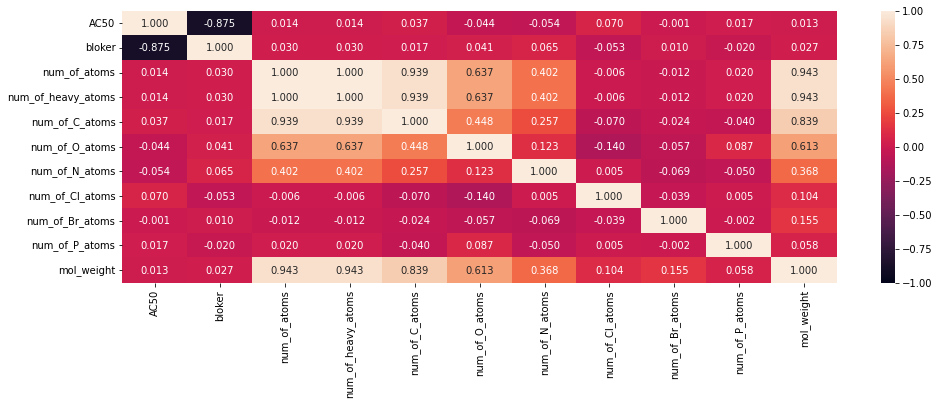

In [26]:
data = data.drop(['molecula'], axis=1)
corr = data.corr()
plt.figure(figsize = (16,5))
sns.heatmap(corr, vmax=1, vmin=-1,
            xticklabels=corr.columns.values,
            yticklabels=corr.columns.values,
            annot=True, fmt=".3f")

In [27]:

data['tpsa'] = df2['molecula'].apply(lambda x: Descriptors.TPSA(x))
data['mol_w'] = df2['molecula'].apply(lambda x: Descriptors.ExactMolWt(x))
data['num_valence_electrons'] = df2['molecula'].apply(lambda x: Descriptors.NumValenceElectrons(x))
data['num_heteroatoms'] = df2['molecula'].apply(lambda x: Descriptors.NumHeteroatoms(x))

ArgumentError: Python argument types in
    rdkit.Chem.rdMolDescriptors.CalcTPSA(NoneType)
did not match C++ signature:
    CalcTPSA(RDKit::ROMol mol, bool force=False, bool includeSandP=False)

In [ ]:
from mol2vec.features import mol2alt_sentence, mol2sentence, MolSentence, DfVec, sentences2vec
from gensim.models import word2vec

# model = word2vec.Word2Vec.load('model_300dim.pkl')
data['sentence'] = df2.apply(lambda x: MolSentence(mol2alt_sentence(x['molecula'], 1)), axis=1)
# data['mol2vec'] = [DfVec(x) for x in sentences2vec(data['sentence'], model, unseen='UNK')]
# data['vec'] = data['mol2vec'].vec
data.head()

In [ ]:
data['sentence_len'] = data['sentence'].apply(len)
data = data.drop(['sentence', 'SMILES'], axis=1)
data.head()

In [ ]:
corr = data.corr()
plt.figure(figsize = (16,5))
sns.heatmap(corr, vmax=1, vmin=-1,
            xticklabels=corr.columns.values,
            yticklabels=corr.columns.values,
            annot=True, fmt=".3f")

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_auc_score
from sklearn.svm import SVC

RANDOM_STATE = np.random.RandomState(1000)
TARGET = 'bloker'
def get_features(data, scaler = None):
    result = data.drop([TARGET, 'AC50'], axis=1)
    if scaler is not None:
        result = scaler.transform(result)
    return result

def get_model_and_scaler_with_RMSE(data):
    target = data[TARGET]
    features = get_features(data)
    features_train, features_valid, target_train, target_valid = train_test_split(features, target, test_size=0.20, random_state=RANDOM_STATE)
    scaler = StandardScaler()
    scaler.fit(features_train)
    features_train = scaler.transform(features_train)
    features_valid = scaler.transform(features_valid)
    linear_regression = SVC(random_state=RANDOM_STATE, probability=True)
    linear_regression.fit(features_train, target_train)

    predictions_valid = linear_regression.predict_proba(features_valid)[:, 1]
    err = roc_auc_score(target_valid, predictions_valid)
    print(f"ROC AUC модели: {err:.2f}")
    return linear_regression, scaler

model, scaler = get_model_and_scaler_with_RMSE(data)

In [ ]:
data['pred'] = model.predict(get_features(data, scaler))
data.describe()

In [ ]:
data[['AC50', 'pred']].head(100)

In [ ]:
data.apply(pd.unique)